In [ ]:
# Running sims, generating stuff
# ssh dpkb@lrc-login.lbl.gov     
# PIN+OTP, scp -r ./[directory] dpkb@lrc-xfer.lbl.gov:/global/home/users/dpkb
# scp -r ./new_sims dpkb@lrc-xfer.lbl.gov:/global/home/users/dpkb
# salloc --account=pc_sealevel --partition lr4 --qos lr_normal
# chmod u+x program_name if executable broken

# scp -r dpkb@lrc-xfer.lbl.gov:/global/home/users/dpkb/runsims.slurm ./MLEF-2024/runsims.slurm

In [230]:
# sensitivity analysis
# Dash Kamriani Beard 07/30/2024
# Lawrence Berkeley National Lab
import subprocess, re, os, shutil, math
import numpy as np

# SET THESE TO YOUR INPUT PATHS
working_sim_dir = "./sensitivity/"
new_sim_dir = "./new_sims/"
chemical_inp = "./sensitivity/chemical.inp"
solute_inp = "./sensitivity/solute.inp"
flow_inp = "./sensitivity/flow.inp"
INCON = "./sensitivity/INCON"
# simulation_results = "./results-2/"

# TEMPERATURE RANGE
temp_start = 35
temp_stop = 100
temp_step = 5

# FACTORS TO MULTIPLY PERMEABILITY BY 
perm_factors = [0.01, 0.1, 0.2, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 1.1, 1.2, 1.3, 1.4, 1.5, 5, 10, 100]

# PARTIAL PRESSURE RANGE - deprecated
# pressure_start = 0.01
# pressure_stop = 0.1
# pressure_step = 0.01

# utility functions

def read_file(path):
    try:
        with open(path, 'r') as file:
            return file.read()
    except FileNotFoundError:
        print(f"The file at {path} was not found.")
    except IOError:
        print(f"An error occurred while reading the file at {path}.")

def split_text(path):
    text = read_file(path).splitlines()
    return text

def split_string_cols(input_string, col_width):
    return [input_string[i:i+col_width] for i in range(0, len(input_string), col_width)]
    
def search_2d_array(array, target):
    flag = 0
    out = []
    for index, text in enumerate(array):
        if flag == 1:
            out.append([index, text])
            flag = 0
        if target in text:
            flag = 1
    return out

def find_specified_non_space(arr, nonspace_index):
    non_space_count = 0

    for index, element in enumerate(arr):
        if element.strip():  # Checks if the element is not empty or whitespace
            non_space_count += 1
            if non_space_count == nonspace_index:
                return [index, element]

    return None, None
    

def copy_directory(source_dir, destination_dir):
    try:
        # Create the destination directory if it doesn't exist
        os.makedirs(destination_dir, exist_ok=True)
        
        # Iterate over all files and subdirectories in the source directory
        for item in os.listdir(source_dir):
            source_item = os.path.join(source_dir, item)
            destination_item = os.path.join(destination_dir, item)
            
            # If it's a file, use shutil.copy2() to copy it while preserving metadata
            if os.path.isfile(source_item):
                shutil.copy2(source_item, destination_item)
            # If it's a directory, recursively call copy_directory()
            elif os.path.isdir(source_item):
                copy_directory(source_item, destination_item)
    
    except Exception as e:
        print(f"Error copying {source_dir} to {destination_dir}: {e}")

def get_sim_data(path):
    text = []
    split = split_text(path)
    for i in range(1, len(split)):
        num_list = []
        for word in split[i].split():
            num_list.append(float(word))
        text.append(num_list)
    return text

# return column data from 2d data array, column index is 0 indexed
def get_col_data(data_2d, col):
    data = []
    for i in data_2d:
        data.append(i[col])
    return np.array(data)

def list_subdirectories(directory):
    subdirs = []
    try:
        for entry in os.listdir(directory):
            full_path = os.path.join(directory, entry)
            if os.path.isdir(full_path):
                subdirs.append(entry)
    except FileNotFoundError:
        print(f"The directory {directory} does not exist.")
    except PermissionError:
        print(f"Permission denied to access the directory {directory}.")
    return subdirs


# Sorting an array by each element's numerical prefix
def extract_number(s):
    # Use a regular expression to find the numerical prefix
    match = re.match(r"(\d+(\.\d+)?)", s)
    if match:
        return float(match.group(1))
    return float('inf')  # In case there is no number

def sort_by_numerical_prefix(arr):
    # Sort the array using the extracted number as the key
    return sorted(arr, key=extract_number)

In [231]:
# chemical.inp, INCON
def vary_temp(path, INCON):

    # put array into a structure -> text[lines][words]
    text = []
    for line in split_text(path):
        words = re.findall(r'\S+|\s+', line)
        text.append(words)

    # find keyword "Speciation" and copy the NEXT row into temperature_row
    temperature_row = search_2d_array(text, "Speciation") 

    # build array of all temperature parameter locations within their respective lines
    temperature = []
    for i in temperature_row: 
        temperature.append(find_specified_non_space(i[1], 2)) 
        
    original_temp = text[temperature_row[0][0]][temperature[0][0]] # store the first original temperature

    # generate files with modified temperature parameter
    for num in range(temp_start, temp_stop + temp_step, temp_step):
        new_text = []
        for i in range(len(temperature_row)):
            text[temperature_row[i][0]][temperature[i][0]] = str(float(num)) # find and replace 
        new_folder_path = f"{new_sim_dir}{num}C"
        copy_directory(working_sim_dir, new_folder_path)
        file_path = f"{new_folder_path}/chemical.inp"
        open(f"{new_folder_path}/chemical.inp", 'w').close()
        for i in range(len(text)):
            new_text.append(''.join(text[i]))
            with open(file_path, 'a') as file:
                file.write(new_text[i] + '\n')
                    
    # dealing with INCON
    incon_text = []
    for line in split_text(INCON):
        words = split_string_cols(line, 10)
        incon_text.append(words)

    for num in range(temp_start, temp_stop + temp_step, temp_step):
        new_text = []
        for i in range(1, len(incon_text)):
            if len(incon_text[i]) == 8:
                incon_text[i][7] = str(float(num)) # find and replace

        new_folder_path = f"{new_sim_dir}{num}C"
        file_path = f"{new_folder_path}/INCON"
        open(f"{new_folder_path}/INCON", 'w').close()
        
        for i in range(len(incon_text)):
            new_text.append(''.join(incon_text[i]))
            with open(file_path, 'a') as file:
                file.write(new_text[i] + '\n')

    return 

vary_temp(chemical_inp, INCON)


In [188]:
# path is to flow.inp file in working simulation
def vary_permeability(path, rock_type):
    
    # put array into a structure -> text[lines][words]
    text = []
    for line in split_text(path):
        words = split_string_cols(line, 10)
        text.append(words)
    perm_row = []
    for i in range(len(text)):
        if len(text[i]) > 0:
            if rock_type in text[i][0]:
                perm_row.append(i)
    
    permX = text[perm_row[0]][3]
    permY = text[perm_row[0]][4]
    permZ = text[perm_row[0]][5]

    # generate files with modified permeability parameter
    for num in perm_factors:
        new_text = []
        for i in range(len(perm_row)):
            text[perm_row[i]][3] = str("{:.4e}".format(float(text[perm_row[i]][3]) * num))
            text[perm_row[i]][4] = str("{:.4e}".format(float(text[perm_row[i]][4]) * num))
            text[perm_row[i]][5] = str("{:.4e}".format(float(text[perm_row[i]][5]) * num))
            
        new_folder_path = f"{new_sim_dir}{num}x"
        copy_directory(working_sim_dir, new_folder_path)
        file_path = f"{new_folder_path}/flow.inp"
        open(f"{new_folder_path}/flow.inp", 'w').close()
        for i in range(len(text)):
            new_text.append(''.join(text[i]))
            with open(file_path, 'a') as file:
                file.write(new_text[i] + '\n')

    return 

vary_permeability(flow_inp, "pillo")


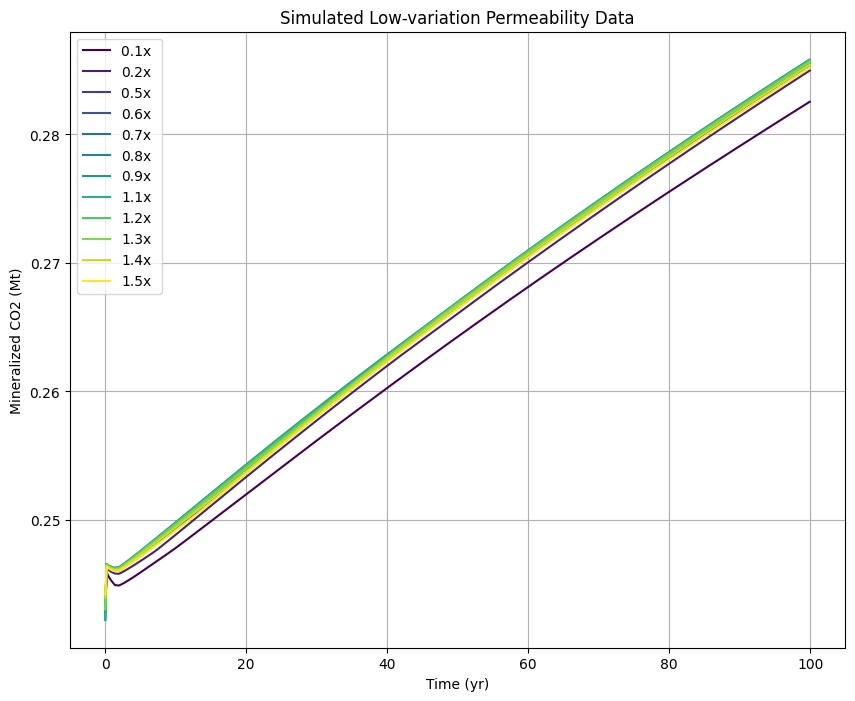

In [239]:
# Plotting data

# Workflow:
# 1. Retrieve the simulation data from the 'CO2trap_tim.out' file located in each 
#    subdirectory within the directory specified by 'simulation_results'
# 2. Plot scaled Mt data from each simulation

def makeplot(simulation_results, sim_name):
    

    import matplotlib.pyplot as plt
    
    dirs = sort_by_numerical_prefix(list_subdirectories(simulation_results))
    data = []
    # 'data' variable is a list of tuples in format: (subdir name, formatted line data from subdir's 'CO2trap_tim.out' file)
    for dir in dirs:
        # print(dir)
        data.append((dir, get_sim_data(f"{simulation_results}{dir}/CO2trap_tim.out")))
    # colors = plt.get_cmap(name='RdYlGn_r', lut=len(data)*3)
    # colors = plt.get_cmap(name='coolwarm', lut=len(data))
    # colors = plt.get_cmap(name="BrBG", lut=len(data))
    colors = plt.get_cmap(name="viridis", lut=len(data))
    
    # Create plot of data from every simulation
    plt.figure(figsize=(10,8))
    plt.xlabel('Time (yr)')
    plt.ylabel('Mineralized CO2 (Mt)')
    for i in range(len(data)):
        dir = data[i][0]
        time = get_col_data(data[i][1], 0)
        sm_co2 = get_col_data(data[i][1], 1)
        sm_co2_scaled = sm_co2 * 1E-9
        aq_co2 = get_col_data(data[i][1], 2)
        plt.plot(time[20:], sm_co2_scaled[20:], color=colors(i), linestyle='-', label=f'{dir}')
        # color=colors(i+math.floor(1.8*len(data)))
    plt.grid()
    plt.title(f"Simulated {sim_name} Data")
    plt.legend()
    plt.savefig(f"{sim_name}.png", dpi=600) # if need to save figure
    plt.show()

# makeplot("./results-1/")
# makeplot("./results-2/perm/", "Permeability")
# makeplot("./results-2/temp/", "Temperature")
# makeplot("./perm_graph/", "Permeability")
makeplot("./no/", "Low-variation Permeability")



# TODO
# vary injection rate 
# make vary_temp based on columns, not second non space (although it might work all the time, still seems sloppy. check docs for what
# columns the temp must be within, then split the line into the proper columns for each parameter in the line)

# is a logical conclusion that we should check back on each of the lines to see 

In [ ]:
# # OUTDATED, could update to injection depth or rate (i think in INCON)

# # designed for chemical.inp
# def vary_pressure_co2(path):

#     # put array into a structure -> text[lines][words]
#     text = []
#     for line in split_text(path):
#         words = re.findall(r'\S+|\s+', line)
#         text.append(words)
        
#     # find keyword "pressure" and copy the NEXT row into pressure_row
#     pressure_row = search_2d_array(text, "pressure") 

#     # build array of all pressure parameter locations within their respective lines
#     pressure = []
#     for i in pressure_row: 
#         pressure.append(find_specified_non_space(i[1], 2)) 
        
#     original_pressure = text[pressure_row[0][0]][pressure[0][0]] # store the first original pressure

#     # generate files with modified pressure parameter
#     pressure_vals = np.arange(pressure_start, pressure_stop + pressure_step, pressure_step)
#     for num in pressure_vals:
#         new_text = []
#         for i in range(len(pressure_row)):
#             text[pressure_row[i][0]][pressure[i][0]] = str(round(num, 4)) # find and replace 
#         path = f"./new_pressures/chemical-{round(num*100, 4)}percentCO2.inp"
#         open(f"./new_pressures/chemical-{round(num*100, 4)}percentCO2.inp", 'w').close()
#         for i in range(len(text)):
#             new_text.append(''.join(text[i]))
#             with open(path, 'a') as file:
#                 file.write(new_text[i] + '\n')
    
#     for i in range(len(pressure_row)):
#             text[pressure_row[i][0]][pressure[i][0]] = original_pressure # find and replace 
#     return

# vary_pressure_co2(chemical_inp)




# DEPRECATED

# def search_2d_array_for_section(array, target):
#     flag = 0
#     out = []
#     for index, text in enumerate(array):
#         if flag == 1:
#             if text:
#                 out.append([index, text])
#             else:
#                 flag = 0
#         if len(text):
#             if target in text[0]:
#                 flag = 1
#     return out

# def runsim():
#     subprocess.check_call([simulation_executable])
#     return

# extra plotting code
# # works for just one
# data = get_sim_data("./simulation-results/95C/CO2trap_tim.out")
# time = get_col_data(data, 0)
# sm_co2 = get_col_data(data, 1)
# sm_co2_scaled = sm_co2 * 1E-9
# aq_co2 = get_col_data(data, 2)
# plt.figure(figsize=(10,5))
# plt.plot(time[20:], sm_co2_scaled[20:], linestyle='-', color='red', label='95C')
# plt.xlabel('Time (yr)')
# plt.ylabel('Mineralized CO2 (Mt)')
# plt.legend()
# plt.show()

# # hard coded for 70-100C
# data = []
# for i in range(70, 105, 5):
#     data.append(get_sim_data(f"./simulation-results/{i}C/CO2trap_tim.out"))
# plt.figure(figsize=(10,5))
# plt.xlabel('Time (yr)')
# plt.ylabel('Mineralized CO2 (Mt)')
# for i in range(len(data)):
#     temp = 5*i+70
#     time = get_col_data(data[i], 0)
#     sm_co2 = get_col_data(data[i], 1)
#     sm_co2_scaled = sm_co2 * 1E-9
#     aq_co2 = get_col_data(data[i], 2)
#     plt.plot(time[:], sm_co2_scaled[:], linestyle='-', label=f'{temp}C')
# plt.legend()
# plt.show()